In [1]:
import numpy as np
import pandas as pd
import sklearn

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
from sklearn.metrics import f1_score
import random
print(sklearn.__version__)


1.4.2


## Mandatory Part

Note: every run you may get different results, so the exact numbers and parameters may differ. However we run everything several times before drawing conclusions so you shouldn't see too much difference when you rerun it.

### 1. Read Data

In [2]:
x = pd.read_csv('TCGAdata.txt', sep=" ", header= 0) #files separated by "" and first column=header

y = pd.read_csv('TCGAlabels.txt',header=0, sep=" ",index_col=0)
y=y["x"]


print("Number of nulls in features:", sum(x.isnull().sum())) # No nulls
print("Number of nulls in labels:", y.isnull().sum())

Number of nulls in features: 0
Number of nulls in labels: 0


### 2. Scale data and Explore PCA

Explore the PCs of the training data in ordet to come up with a potential number of principal components to be chosen. How to select PCs?

- Ratio of explained variance: Each PC indicates the variance along the direction of its principal component. Select the amount of vaiance as a % of varaince to be explained i.e. 90% of explained variance

- Elbow method: make a scree plot to see the significance of each component

- Cross validation: when PCA is followed by regression/classification, we can make the number of principal components k as a varaible to chose in the pipeline, therefore it can be trained


PCA is fitted better after standarizing the data, as some features can be more widespread than others. For example, height of a person could go from 160cm to 190cm, but the net worth of a person could go from 0€ to Millions of €. We also apply the technique only to the train data, as the test data is the one we want to use to simulate our predictions.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.50)#Split the data into training and test sets
X_pp = StandardScaler().fit_transform(X_train) #center data
pca=PCA()
pca_data = pca.fit_transform(X_pp) #compute PCA


#### 2.1 Ratio of explained variance

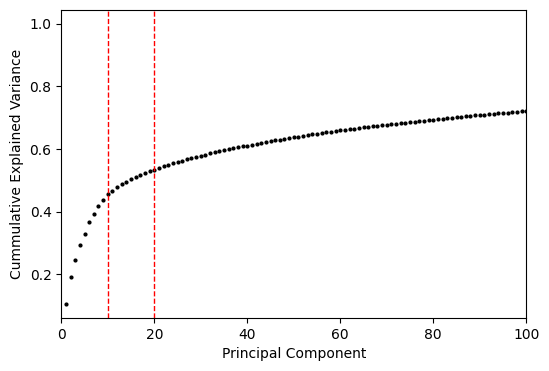

In [4]:
#compute cumulative variance of the principal components
cum_var=len(pca.explained_variance_ratio_)*[0]
cum_var[0]=pca.explained_variance_ratio_[0]
for i in range(1,len(cum_var)):
    cum_var[i]=cum_var[i-1]+pca.explained_variance_ratio_[i]
    # print(cum_var[i])

#plot it
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.plot(np.arange(1, len(pca.explained_variance_) + 1), cum_var, 'ok', markersize=2)
ax.axvline(10, linestyle="dashed", color="red", linewidth=1)
ax.axvline(20, linestyle="dashed", color="red", linewidth=1)
plt.xlim(0, 100)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Cummulative Explained Variance");

From the explained variance ratio plot, we think we should be willing to try with something between 10 and 20 PCs

#### 2.2 Elbow method

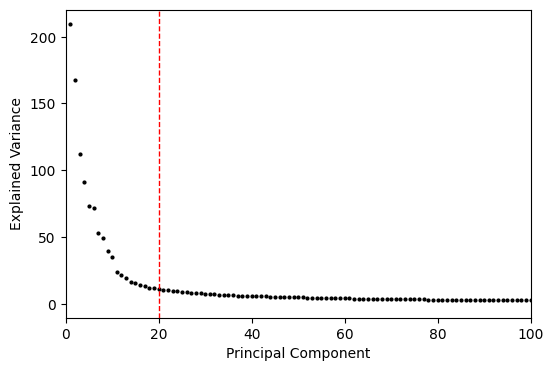

In [5]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.plot(np.arange(1, len(pca.explained_variance_) + 1), pca.explained_variance_, 'ok', markersize=2)
ax.axvline(20, linestyle="dashed", color="red", linewidth=1)
plt.xlim(0, 100)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance");

The elbow method suggests around 20 PCs.

#### 2.3 Cross-Validation PCA

To do that, PCA will be considered as part of model training rather than data preprocessing. We defined a pipeline that consits on: scale data, apply PCA and finally apply a classification model. The pipeline parameters will be the number of principal components and the classifier parameters. After determining the best parameters through cross-validation we will evaluate the test set with these parameters. This can be easily implemented with Pipeline() and GridSearchCV().

The methods we tried were:
- KNN (data-based)
- Logistic regression(model-based discriminative)
- Discriminant Analysis(model-based generative)



##### 2.3.1 K nearest neighbors
The only assumption is that the closer 2 points the more similar they are. However the notion of distance breaks down in high dimensioanl spaces, that is why PCA can be very useful. I will be using the default distance metric implemented in python: Euclidean distance.

Also, note that we chose to cross-validate with 10 folds because it is a standard number, and the GridSearchCV score (which is the score used to select the best parameters) will be the balanced accuracy, a type of accuracy that performs better in unblanced datasets like our dataset

In [6]:
#Cross-validation pipeline of Standarize + PCA + KNN
pipe = Pipeline([("scale", StandardScaler()),
                 ("reduce_dims", PCA()),
                 ("knn", KNeighborsClassifier())])

#parameters to try
param_grid = dict(reduce_dims__n_components = [20,30,40], #decided from previous section
                  knn__n_neighbors=[1,3,5,7]) #standard values to try

#perform cross validation in the given pipeline
grid = GridSearchCV(pipe, param_grid=param_grid, cv=10, scoring="balanced_accuracy")
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print('Best parameters obtained from Grid Search:\n', grid.best_params_)

Best parameters obtained from Grid Search:
 {'knn__n_neighbors': 5, 'reduce_dims__n_components': 30}


Classification report test set


In [7]:
grid_predictions = grid.predict(X_test)
# print classification report
print('Classification result for train data')
print(classification_report(y_train, grid.predict(X_train)))
print('Classification result for test data')

print(classification_report(y_test, grid_predictions))

#===========
best_params = grid.best_params_
print("Keys present in best_params:", best_params.keys())

# Create a new pipeline with the best parameters
best_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("reduce_dims", PCA(n_components=best_params['reduce_dims__n_components'])),
    ("knn", KNeighborsClassifier(n_neighbors=best_params['knn__n_neighbors']))
])

# Perform cross-validation with the new pipeline
cv_predictions_best_params = cross_val_predict(best_pipe, X_train, y_train, cv=10)

# Print classification report for cross-validation with best parameters
print("Classification Report for Cross-Validation with Best Parameters:")
print(classification_report(y_train, cv_predictions_best_params))

Classification result for train data
              precision    recall  f1-score   support

          BC       0.99      1.00      0.99       632
         GBM       0.99      0.99      0.99        84
          KI       1.00      0.99      0.99       302
          LU       1.00      0.99      1.00       264
          OV       1.00      0.99      1.00       132
           U       0.93      0.93      0.93        29

    accuracy                           0.99      1443
   macro avg       0.98      0.98      0.98      1443
weighted avg       0.99      0.99      0.99      1443

Classification result for test data
              precision    recall  f1-score   support

          BC       0.98      1.00      0.99       583
         GBM       1.00      0.99      0.99        88
          KI       1.00      0.99      1.00       304
          LU       1.00      0.99      0.99       307
          OV       1.00      0.99      1.00       134
           U       0.89      0.89      0.89        28

    

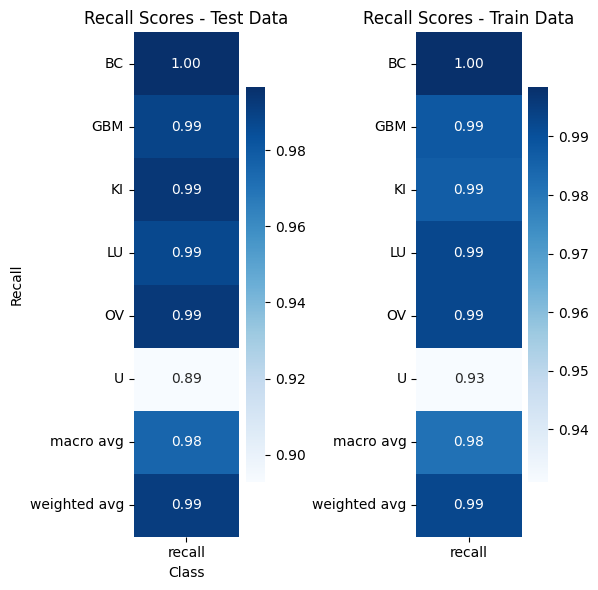

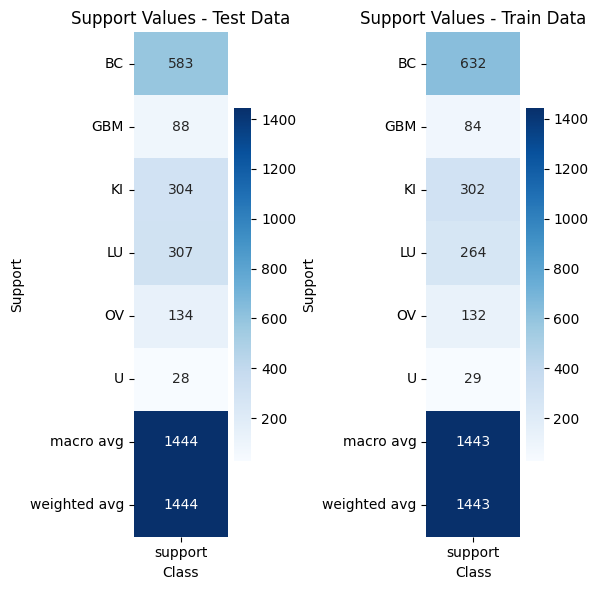

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

# Get the classification report
report_knn = classification_report(y_test, grid_predictions, output_dict=True)
report_train_knn = classification_report(y_train, grid.predict(X_train), output_dict=True)

# Extract recall, precision, and support values from the report
recall_values_knn = {class_label: report_knn[class_label]['recall'] for class_label in report_knn if class_label != 'accuracy'}
recall_values_train_knn = {class_label: report_train_knn[class_label]['recall'] for class_label in report_train_knn if class_label != 'accuracy'}

# precision_values = {class_label: report[class_label]['precision'] for class_label in report if class_label != 'accuracy'}
support_valuestest_knn = {class_label: report_knn[class_label]['support'] for class_label in report_knn if class_label != 'accuracy'}
support_valuestrain_knn  = {class_label: report_train_knn[class_label]['support'] for class_label in report_train_knn if class_label != 'accuracy'}

# Convert recall, precision, and support values to DataFrames
recall_df = pd.DataFrame.from_dict(recall_values_knn, orient='index', columns=['recall'])
recall_df_train = pd.DataFrame.from_dict(recall_values_train_knn, orient='index', columns=['recall'])

# precision_df = pd.DataFrame.from_dict(recall_values_train, orient='index', columns=['precision'])
support_df = pd.DataFrame.from_dict(support_valuestest_knn, orient='index', columns=['support'])
suport_train = pd.DataFrame.from_dict(support_valuestrain_knn, orient='index', columns=['support'])

# Plot recall, precision, and support values
fig, axes = plt.subplots(1, 2, figsize=(6, 6))

sns.heatmap(recall_df, annot=True, cmap='Blues', fmt='.2f', cbar=True, ax=axes[0])
axes[1].set_title('Recall Scores - Train Data')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Recall')

sns.heatmap(recall_df_train, annot=True, cmap='Blues', fmt='.2f', cbar=True, ax=axes[1])
axes[0].set_title('Recall Scores - Test Data')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Recall')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(6, 6))
sns.heatmap(suport_train, annot=True, cmap='Blues', fmt='.0f', cbar=True, ax=axes[1])
axes[1].set_title('Support Values - Train Data')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Support')

sns.heatmap(support_df, annot=True, cmap='Blues', fmt='.0f', cbar=True, ax=axes[0])
axes[0].set_title('Support Values - Test Data')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Support')
plt.tight_layout()
plt.show()



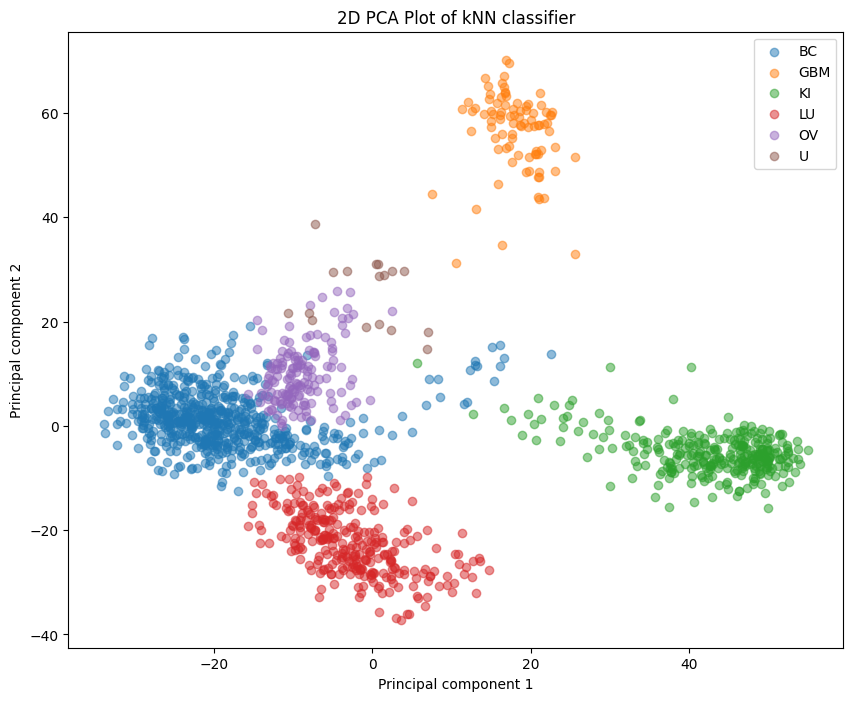

In [9]:
#### Visualization of kNN classfier results only for pc1 and pc2
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=best_params['knn__n_neighbors'])
knn.fit(X_train_pca, y_train)

test_predictions = knn.predict(X_test_pca)

colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(np.unique(y_test)):
    plt.scatter(X_test_pca[test_predictions == class_label, 0], X_test_pca[test_predictions == class_label, 1],
                color=colors[i], label=class_label, alpha=0.5)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('2D PCA Plot of kNN classifier')
plt.legend()
plt.show()

Conclusion:
For all of 6 different classes, all the general measures are high.
Even number of samples in GBM are low, the test results are good.
The errors in class U is higher since number of samples of U class in training set is relatively low.


##### 2.3.2 Logistic Regression
Uses the similarity of the logistic function with the standard normal CDF to classify the data after applying a linear transformation to it. If its greater than 0.5 it will be to class 1, lower it will belong to the otehr class. This is, a model approximation for p(i|x). The original model is for binary classification but it can be extended to multi class.

Assumptions:
- Binary classification (extended to multiclass using softmax)
- No multicollinearity (reduced with PCA)
- Large sample (sample of 2000)
- Linear relationshiip of variables to log odds (to be tested)
- No outliers (to be tested)
- Independent oservations (to be tested)

In [10]:
#Cross-validation pipeline of Standarize + PCA + Logistic
pipe = Pipeline([("scale", StandardScaler()),
                 ("reduce_dims", PCA()),
                 ("logistic", LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=1000))])

#parameters to try
param_grid = dict(reduce_dims__n_components = [20,30,40])

#cross-validation in our pipeline
logistic_grid = GridSearchCV(pipe, param_grid=param_grid, cv=10, scoring="balanced_accuracy") #perform cross validation in the given pipelin
logistic_grid.fit(X_train, y_train)

print('Best parameters obtained from Grid Search:\n', logistic_grid.best_params_)

Best parameters obtained from Grid Search:
 {'reduce_dims__n_components': 20}


Classification report test set

In [11]:
logistic_grid_predictions = logistic_grid.predict(X_test)

# print classification report
print('Classification result for train data')
print(classification_report(y_train, logistic_grid.predict(X_train)))

print('Classification result for test data')
print(classification_report(y_test, logistic_grid_predictions))

#===========
best_params = logistic_grid.best_params_
print("Keys present in best_params:", best_params.keys())

# Create a new pipeline with the best parameters
best_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("reduce_dims", PCA(n_components=best_params['reduce_dims__n_components'])),
    ("logistic", LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=1000))
])

# Perform cross-validation with the new pipeline
cv_predictions_best_params = cross_val_predict(best_pipe, X_train, y_train, cv=10)

# Print classification report for cross-validation with best parameters
print("Classification Report for Cross-Validation with Best Parameters:")
print(classification_report(y_train, cv_predictions_best_params))

Classification result for train data
              precision    recall  f1-score   support

          BC       1.00      1.00      1.00       632
         GBM       1.00      1.00      1.00        84
          KI       1.00      1.00      1.00       302
          LU       1.00      1.00      1.00       264
          OV       1.00      1.00      1.00       132
           U       1.00      1.00      1.00        29

    accuracy                           1.00      1443
   macro avg       1.00      1.00      1.00      1443
weighted avg       1.00      1.00      1.00      1443

Classification result for test data
              precision    recall  f1-score   support

          BC       0.99      1.00      1.00       583
         GBM       1.00      0.99      0.99        88
          KI       0.99      1.00      1.00       304
          LU       0.99      0.99      0.99       307
          OV       1.00      0.99      1.00       134
           U       0.92      0.86      0.89        28

    

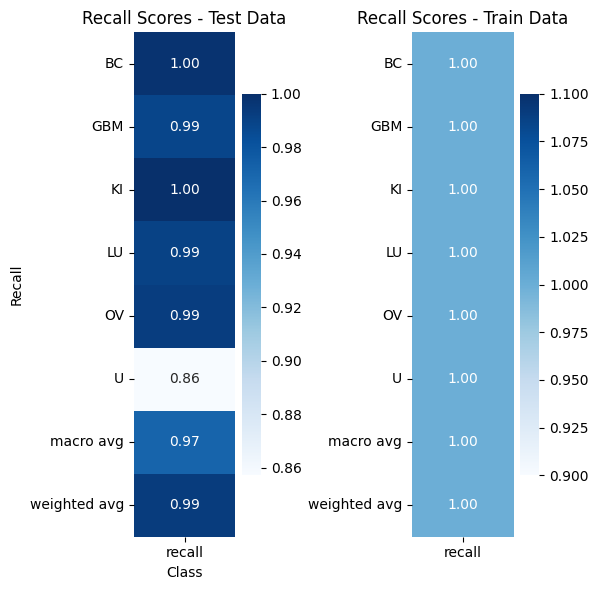

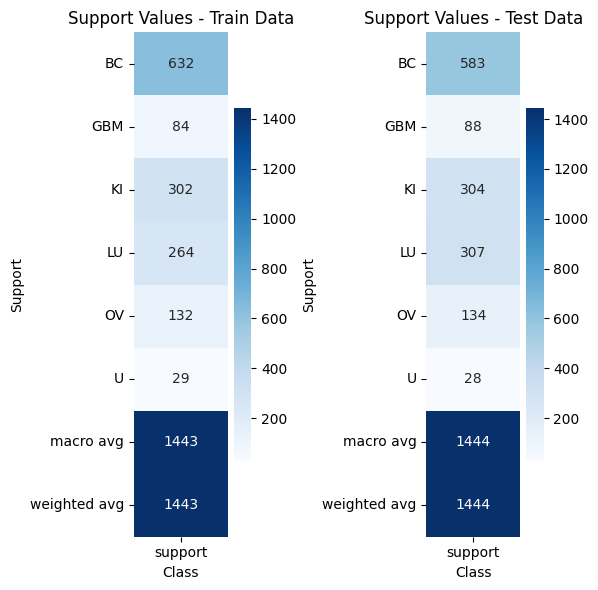

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

report = classification_report(y_test, logistic_grid_predictions, output_dict=True)
report_train = classification_report(y_train, logistic_grid.predict(X_train), output_dict=True)

# Extract recall, precision, and support values from the report
recall_values = {class_label: report[class_label]['recall'] for class_label in report if class_label != 'accuracy'}
recall_values_train = {class_label: report_train[class_label]['recall'] for class_label in report_train if class_label != 'accuracy'}

# precision_values = {class_label: report[class_label]['precision'] for class_label in report if class_label != 'accuracy'}
support_valuestest = {class_label: report[class_label]['support'] for class_label in report if class_label != 'accuracy'}
support_valuestrain  = {class_label: report_train[class_label]['support'] for class_label in report_train if class_label != 'accuracy'}

recall_df = pd.DataFrame.from_dict(recall_values, orient='index', columns=['recall'])
recall_df_train = pd.DataFrame.from_dict(recall_values_train, orient='index', columns=['recall'])

# precision_df = pd.DataFrame.from_dict(recall_values_train, orient='index', columns=['precision'])
support_df = pd.DataFrame.from_dict(support_valuestest, orient='index', columns=['support'])
suport_train = pd.DataFrame.from_dict(support_valuestrain, orient='index', columns=['support'])

fig, axes = plt.subplots(1, 2, figsize=(6, 6))

sns.heatmap(recall_df, annot=True, cmap='Blues', fmt='.2f', cbar=True, ax=axes[0])
axes[1].set_title('Recall Scores - Train Data')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Recall')

sns.heatmap(recall_df_train, annot=True, cmap='Blues', fmt='.2f', cbar=True, ax=axes[1])
axes[0].set_title('Recall Scores - Test Data')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Recall')
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(6, 6))

sns.heatmap(suport_train, annot=True, cmap='Blues', fmt='.0f', cbar=True, ax=axes[0])
axes[0].set_title('Support Values - Train Data')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Support')

sns.heatmap(support_df, annot=True, cmap='Blues', fmt='.0f', cbar=True, ax=axes[1])
axes[1].set_title('Support Values - Test Data')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Support')

plt.tight_layout()
plt.show()


##### 2.3.3 Quadratic Discriminant Analysis
Finally, we use QDA (the more flexible discriminant analysis) to model p(x,i) assuming that p(x|i) is normal and estimating the prior p(i) from the data.

Assumptions:
- p(x|i) ~ Normal (should be tested)
- QDA assumes that each class has its own covariance matrix

In [13]:
#Cross-validation pipeline of Standarize + PCA + QDA
pipe = Pipeline([("scale", StandardScaler()),
                 ("reduce_dims", PCA()),
                 ("QDA", QuadraticDiscriminantAnalysis())])

#parameter definition
param_grid = dict(reduce_dims__n_components = [20,30,40])

#pipeline training
QDA_grid = GridSearchCV(pipe, param_grid=param_grid, cv=10) #perform cross validation in the given pipelin
QDA_grid.fit(X_train, y_train)
print('Best parameters obtained from Grid Search:\n', QDA_grid.best_params_)

c:\Users\purus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\purus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\purus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\purus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\purus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\purus\AppData\Local\Programs\Python\

Best parameters obtained from Grid Search:
 {'reduce_dims__n_components': 20}


Classification report test set

In [14]:
grid_predictions = QDA_grid.predict(X_test)

# print classification report
print('Classification result for train data')
print(classification_report(y_train, QDA_grid.predict(X_train)))

print('Classification result for test data')
print(classification_report(y_test, grid_predictions))

best_params = QDA_grid.best_params_
print("Keys present in best_params:", best_params.keys())

# Create a new pipeline with the best parameters
best_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("reduce_dims", PCA(n_components=best_params['reduce_dims__n_components'])),
    ("QDA", QuadraticDiscriminantAnalysis())
])

# Perform cross-validation with the new pipeline
cv_predictions_best_params = cross_val_predict(best_pipe, X_train, y_train, cv=10)

# Print classification report for cross-validation with best parameters
print("Classification Report for Cross-Validation with Best Parameters:")
print(classification_report(y_train, cv_predictions_best_params))

Classification result for train data
              precision    recall  f1-score   support

          BC       1.00      1.00      1.00       632
         GBM       0.99      1.00      0.99        84
          KI       1.00      1.00      1.00       302
          LU       0.99      1.00      1.00       264
          OV       1.00      1.00      1.00       132
           U       1.00      1.00      1.00        29

    accuracy                           1.00      1443
   macro avg       1.00      1.00      1.00      1443
weighted avg       1.00      1.00      1.00      1443

Classification result for test data
              precision    recall  f1-score   support

          BC       1.00      1.00      1.00       583
         GBM       1.00      0.99      0.99        88
          KI       1.00      1.00      1.00       304
          LU       0.99      0.99      0.99       307
          OV       0.99      1.00      1.00       134
           U       0.86      0.86      0.86        28

    

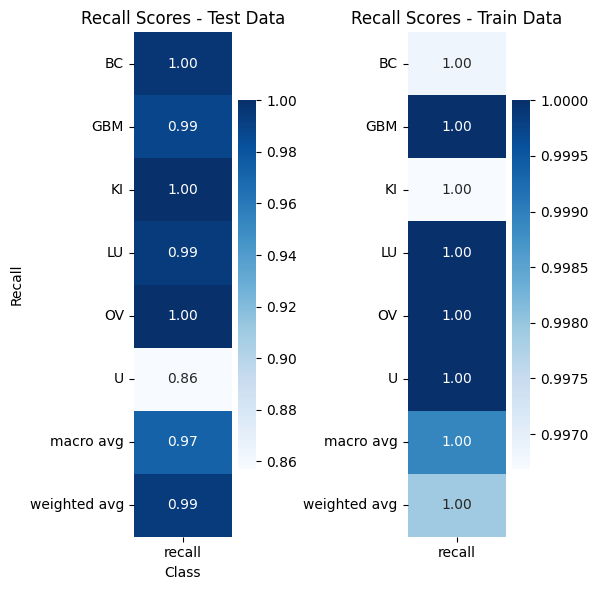

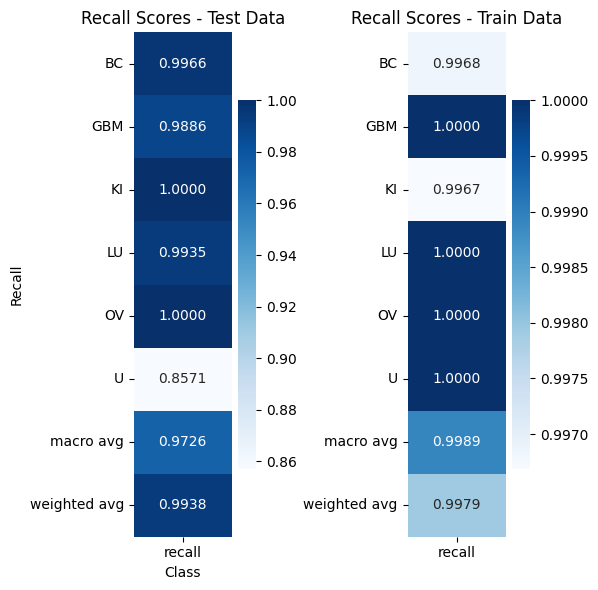

In [15]:


# Get the classification report
report = classification_report(y_test, grid_predictions, output_dict=True)
report_train = classification_report(y_train, QDA_grid.predict(X_train), output_dict=True)

# Extract recall, precision, and support values from the report
recall_values = {class_label: report[class_label]['recall'] for class_label in report if class_label != 'accuracy'}
recall_values_train = {class_label: report_train[class_label]['recall'] for class_label in report_train if class_label != 'accuracy'}

# precision_values = {class_label: report[class_label]['precision'] for class_label in report if class_label != 'accuracy'}
support_valuestest = {class_label: report[class_label]['support'] for class_label in report if class_label != 'accuracy'}
support_valuestrain  = {class_label: report_train[class_label]['support'] for class_label in report_train if class_label != 'accuracy'}

# Convert recall, precision, and support values to DataFrames
recall_df = pd.DataFrame.from_dict(recall_values, orient='index', columns=['recall'])
recall_df_train = pd.DataFrame.from_dict(recall_values_train, orient='index', columns=['recall'])

# precision_df = pd.DataFrame.from_dict(recall_values_train, orient='index', columns=['precision'])
support_df = pd.DataFrame.from_dict(support_valuestest, orient='index', columns=['support'])
suport_train = pd.DataFrame.from_dict(support_valuestrain, orient='index', columns=['support'])

# Plot recall, precision, and support values
fig, axes = plt.subplots(1, 2, figsize=(6, 6))

sns.heatmap(recall_df, annot=True, cmap='Blues', fmt='.2f', cbar=True, ax=axes[0])
axes[1].set_title('Recall Scores - Train Data')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Recall')

sns.heatmap(recall_df_train, annot=True, cmap='Blues', fmt='.2f', cbar=True, ax=axes[1])
axes[0].set_title('Recall Scores - Test Data')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Recall')
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(6, 6))

sns.heatmap(recall_df, annot=True, cmap='Blues', fmt='.4f', cbar=True, ax=axes[0])
axes[1].set_title('Recall Scores - Train Data')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Recall')

sns.heatmap(recall_df_train, annot=True, cmap='Blues', fmt='.4f', cbar=True, ax=axes[1])
axes[0].set_title('Recall Scores - Test Data')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Recall')
plt.tight_layout()
plt.show()


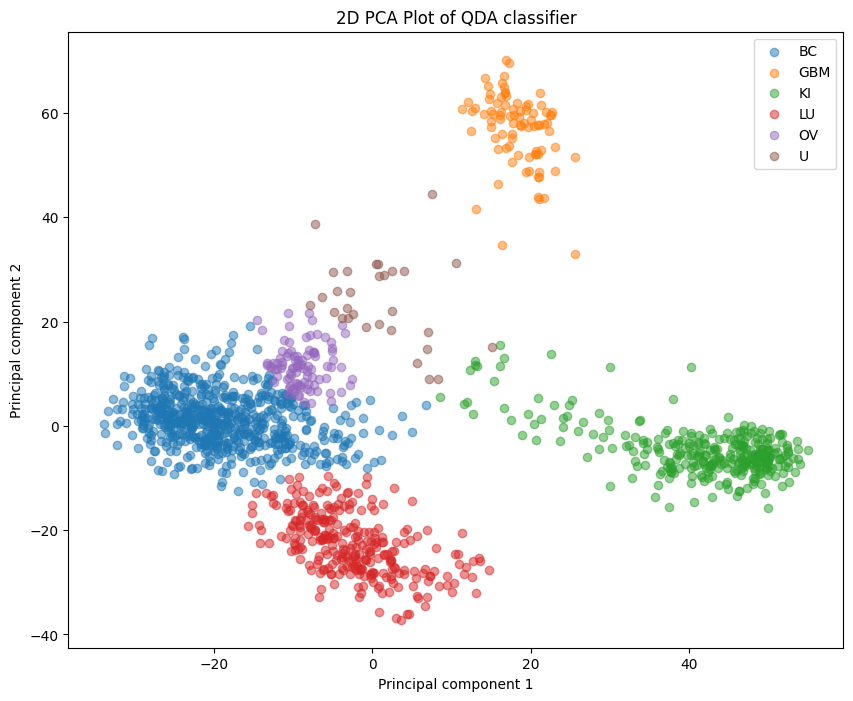

In [16]:
#### Visualization of QDA classfier results only for pc1 and pc2
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_pca, y_train)

test_predictions = qda.predict(X_test_pca)

colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(np.unique(y_test)):
    plt.scatter(X_test_pca[test_predictions == class_label, 0], X_test_pca[test_predictions == class_label, 1],
                color=colors[i], label=class_label, alpha=0.5)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('2D PCA Plot of QDA classifier')
plt.legend()
plt.show()

##### 2.3.4 Conclusion

In conclusion, we tested 3 different type of classification algortihms: knn, logistic regression and QDA. Overall the three models work quite good, being logistic regression the one that performs best overall (in some runs Knn was slighlty better but after running everything several times ther was a clear tendency for logistic regression to be better).

The most flexible model was knn, which only assumed similarity between close data points, while logistic regression can be
considered the most restrictive, as it had more assumptions on the model. On the other hand QDA had fewer assumptions, but stronger to meet.

Logistic regression with no PCA

In [17]:
logr = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=1000)
logr.fit(X_train,y_train)

predicted = logr.predict(X_test)
print('Classification result for train data')
print(classification_report(y_train, logr.predict(X_train)))

print('Classification result for test data')
print(classification_report(y_test, predicted))

cv_predictions = cross_val_predict(logr, X_train, y_train, cv=10)

print(classification_report(y_train, cv_predictions))


Classification result for train data
              precision    recall  f1-score   support

          BC       1.00      1.00      1.00       632
         GBM       1.00      1.00      1.00        84
          KI       1.00      1.00      1.00       302
          LU       1.00      1.00      1.00       264
          OV       1.00      1.00      1.00       132
           U       1.00      1.00      1.00        29

    accuracy                           1.00      1443
   macro avg       1.00      1.00      1.00      1443
weighted avg       1.00      1.00      1.00      1443

Classification result for test data
              precision    recall  f1-score   support

          BC       1.00      1.00      1.00       583
         GBM       1.00      1.00      1.00        88
          KI       0.99      1.00      1.00       304
          LU       1.00      0.99      1.00       307
          OV       1.00      0.99      0.99       134
           U       0.87      0.96      0.92        28

    

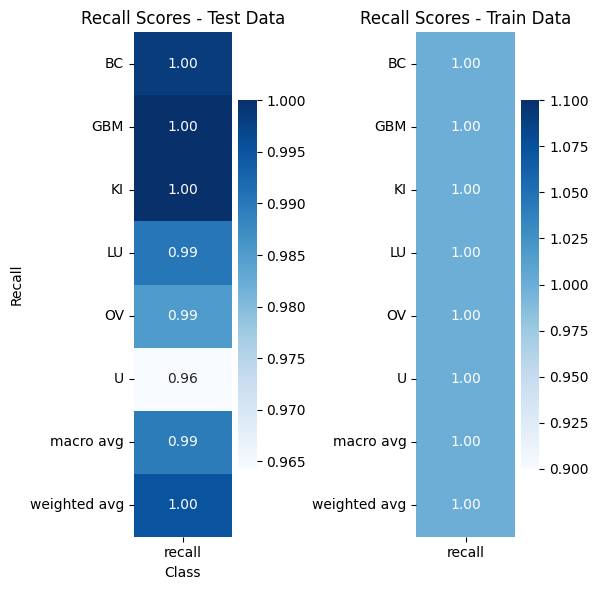

In [18]:


# Get the classification report
report = classification_report(y_test, predicted, output_dict=True)
report_train = classification_report(y_train, logr.predict(X_train), output_dict=True)

# Extract recall, precision, and support values from the report
recall_values = {class_label: report[class_label]['recall'] for class_label in report if class_label != 'accuracy'}
recall_values_train = {class_label: report_train[class_label]['recall'] for class_label in report_train if class_label != 'accuracy'}

# precision_values = {class_label: report[class_label]['precision'] for class_label in report if class_label != 'accuracy'}
support_valuestest = {class_label: report[class_label]['support'] for class_label in report if class_label != 'accuracy'}
support_valuestrain  = {class_label: report_train[class_label]['support'] for class_label in report_train if class_label != 'accuracy'}

# Convert recall, precision, and support values to DataFrames
recall_df = pd.DataFrame.from_dict(recall_values, orient='index', columns=['recall'])
recall_df_train = pd.DataFrame.from_dict(recall_values_train, orient='index', columns=['recall'])

# precision_df = pd.DataFrame.from_dict(recall_values_train, orient='index', columns=['precision'])
support_df = pd.DataFrame.from_dict(support_valuestest, orient='index', columns=['support'])
suport_train = pd.DataFrame.from_dict(support_valuestrain, orient='index', columns=['support'])

# Plot recall, precision, and support values
fig, axes = plt.subplots(1, 2, figsize=(6, 6))

sns.heatmap(recall_df, annot=True, cmap='Blues', fmt='.2f', cbar=True, ax=axes[0])
axes[1].set_title('Recall Scores - Train Data')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Recall')

sns.heatmap(recall_df_train, annot=True, cmap='Blues', fmt='.2f', cbar=True, ax=axes[1])
axes[0].set_title('Recall Scores - Test Data')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Recall')
plt.tight_layout()
plt.show()




Logistic Regression PCA

In [58]:
print(classification_report(y_test, logistic_grid_predictions))

              precision    recall  f1-score   support

          BC       1.00      1.00      1.00       235
         GBM       1.00      1.00      1.00        25
          KI       1.00      1.00      1.00       124
          LU       1.00      0.98      0.99       119
          OV       1.00      1.00      1.00        62
           U       0.93      1.00      0.96        13

    accuracy                           1.00       578
   macro avg       0.99      1.00      0.99       578
weighted avg       1.00      1.00      1.00       578



Additionally, we can see that if we don't apply the PCA the model performs slightly better (in the order of 0.01), which I think we should use in this case as there are not many samples. However, as the number of samples increases applying PCA could be very useful to reduce computation time and avoid some spurious correlations, as the results obtained applying PCA are almost identical, but simplify the dataset quite a bit.

### 3. Cross-Validation Feature Selection

In this section I am going to make the same than before but instead of reducing dimensions using PCA, I will focus on a smart feature selection, that is features with maximum variance, features that correlate more with the response (ANOVA F-score) and recursive feature elimination. Other well-known techniques are recursive feature selection, Mutual Information Entropy, variable importance with random forests and Lasso regression. The methods applied come from the sklearn.feature_selection library.

I only applied it to logistic regression so I could focus on studying the different techniques deeper.

#### 3.1 Removing features with minimum variance

First of all I plotted the variance of each feature to get and idea.

(2309, 2000)


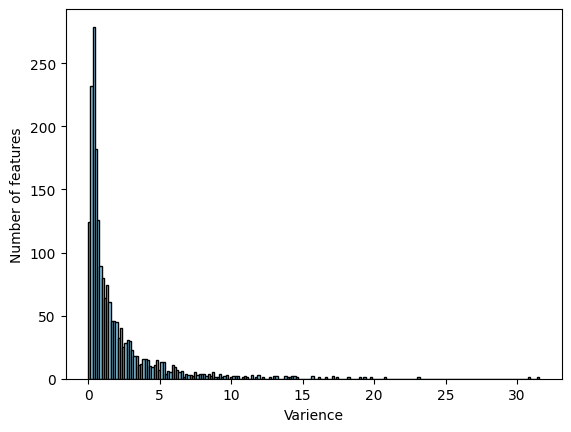

In [59]:
# Plotting ahistogram
var= X_train.var(axis='rows')
print(X_train.shape)
plt.hist(var, bins=200, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Varience')
plt.ylabel('Number of features')

# Display the plot
plt.show()

Overall this plot reminds a bit to the PCA plot: most of the features are not very important in terms of variance. Also I realized that we have some features with 0 variance, which means that all the values are the same so they can be removed. I think that  a good starting point is removing these majority of features with lower variance (around 5).

In [60]:
#Cross-validation pipeline
pipe = Pipeline([
    ('feature_selection', VarianceThreshold()),
    ("logistic", LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=1000))
])

#variance threshold (0,5,7,10)
param_grid = dict(feature_selection__threshold=[0,1,5,2,10])

#cross validation for the different variance thresholds
logistic_grid = GridSearchCV(pipe, param_grid=param_grid, cv=10,scoring="balanced_accuracy")
#cross validation for threshold=10
grid2 = GridSearchCV(pipe, param_grid=dict(feature_selection__threshold=[7]) , cv=10,scoring="balanced_accuracy" ) #perfosrm cross validation in the given pipelin

#fit the 2 grids
logistic_grid.fit(X_train, y_train)
grid2.fit(X_train, y_train)

print('Best parameters obtained from Grid Search:\n', logistic_grid.best_params_)

Best parameters obtained from Grid Search:
 {'feature_selection__threshold': 0}


In the obtained results we can see that, similar to the PCA case, the most predictive power is in only removing the constant features (variance threshold=0). However, for the same reasons as before we decided to print the results of the grid training and observe that the mean_test_score is of 0.99, but when chosing a threshold of 7 the score is of 0.98, which means that removing most of the features we can get very similar prediciton power.

In [61]:
pd.DataFrame(grid.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_reduce_dims__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.243362,0.028771,0.026319,0.012006,1,20,"{'knn__n_neighbors': 1, 'reduce_dims__n_compon...",0.964966,0.987963,0.985185,1.000000,0.954861,0.956633,0.998299,0.991355,1.000000,1.000000,0.983926,0.017332,3
1,0.376833,0.075076,0.029267,0.015129,1,30,"{'knn__n_neighbors': 1, 'reduce_dims__n_compon...",0.964966,1.000000,0.987188,1.000000,0.954861,0.958333,0.998299,0.993056,1.000000,1.000000,0.985670,0.017784,1
2,0.652128,0.558046,0.034773,0.024362,1,40,"{'knn__n_neighbors': 1, 'reduce_dims__n_compon...",0.961565,1.000000,0.979252,1.000000,0.996528,0.958333,0.998299,0.951389,1.000000,1.000000,0.984537,0.019054,2
3,0.333941,0.272590,0.026058,0.007714,3,20,"{'knn__n_neighbors': 3, 'reduce_dims__n_compon...",0.964966,0.996296,0.990892,1.000000,0.954861,0.954861,0.987188,0.991355,0.996528,0.988095,0.982504,0.016525,5
4,0.403652,0.168072,0.021970,0.002235,3,30,"{'knn__n_neighbors': 3, 'reduce_dims__n_compon...",0.964966,1.000000,0.992593,1.000000,0.954861,0.954861,0.987188,0.993056,0.996528,0.984623,0.982868,0.016979,4
5,0.448272,0.281052,0.029064,0.008675,3,40,"{'knn__n_neighbors': 3, 'reduce_dims__n_compon...",0.961565,0.996296,0.992593,1.000000,0.954861,0.954861,0.987188,0.993056,0.963194,0.984623,0.978824,0.017146,8
6,0.257149,0.046439,0.035694,0.019248,5,20,"{'knn__n_neighbors': 5, 'reduce_dims__n_compon...",0.961565,0.991667,0.990892,0.958333,0.954861,0.996528,0.985488,0.991355,0.996528,0.954762,0.978198,0.017337,11
7,0.301886,0.036166,0.027392,0.005872,5,30,"{'knn__n_neighbors': 5, 'reduce_dims__n_compon...",0.964966,0.987963,0.992593,1.000000,0.954861,0.996528,0.987188,0.993056,0.996528,0.951290,0.982497,0.017350,6
8,0.550734,0.315120,0.031720,0.011152,5,40,"{'knn__n_neighbors': 5, 'reduce_dims__n_compon...",0.959864,0.991667,0.992593,1.000000,0.954861,0.996528,0.987188,0.993056,0.996528,0.951290,0.982357,0.018081,7
9,0.428186,0.348315,0.058370,0.092584,7,20,"{'knn__n_neighbors': 7, 'reduce_dims__n_compon...",0.961565,0.991667,0.992593,1.000000,0.954861,0.996528,0.985488,0.949688,0.996528,0.951290,0.978021,0.019867,12


In [62]:
print(X_train.shape)

(2309, 2000)


Test score of Variance Threshold 0

In [63]:
logistic_grid_predictions = logistic_grid.predict(X_test)

# print classification report
print('Classification result for train data')
print(classification_report(y_train, logistic_grid.predict(X_train)))
print('Classification result for test data')

print(classification_report(y_test, logistic_grid_predictions))

best_params = logistic_grid.best_params_
print("Keys present in best_params:", best_params.keys())

# Create a new pipeline with the best parameters
best_pipe = Pipeline([
    ('feature_selection', VarianceThreshold(threshold=best_params['feature_selection__threshold'])),
    ("logistic", LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=1000))
])

# Perform cross-validation with the new pipeline
cv_predictions_best_params = cross_val_predict(best_pipe, X_train, y_train, cv=10)

# Print classification report for cross-validation with best parameters
print("Classification Report for Cross-Validation with Best Parameters:")
print(classification_report(y_train, cv_predictions_best_params))


Classification result for train data
              precision    recall  f1-score   support

          BC       1.00      1.00      1.00       980
         GBM       1.00      1.00      1.00       147
          KI       1.00      1.00      1.00       482
          LU       1.00      1.00      1.00       452
          OV       1.00      1.00      1.00       204
           U       1.00      1.00      1.00        44

    accuracy                           1.00      2309
   macro avg       1.00      1.00      1.00      2309
weighted avg       1.00      1.00      1.00      2309

Classification result for test data
              precision    recall  f1-score   support

          BC       1.00      1.00      1.00       235
         GBM       1.00      1.00      1.00        25
          KI       0.99      1.00      1.00       124
          LU       1.00      0.97      0.99       119
          OV       1.00      1.00      1.00        62
           U       0.87      1.00      0.93        13

    

Test score of Variance Threshold 7

In [64]:
grid_predictions2 = grid2.predict(X_test)

# print classification report
print(classification_report(y_test, grid_predictions2))

              precision    recall  f1-score   support

          BC       1.00      1.00      1.00       235
         GBM       1.00      1.00      1.00        25
          KI       0.99      0.99      0.99       124
          LU       0.99      0.97      0.98       119
          OV       0.97      0.98      0.98        62
           U       0.79      0.85      0.81        13

    accuracy                           0.99       578
   macro avg       0.96      0.97      0.96       578
weighted avg       0.99      0.99      0.99       578



As said, the difference between removing none of the features and most of the features is very small, so even though with this dataset it would be okay to not remove anything, we have proven that as it gets bigger and complex we would be able to make it much more simpler in order to get a siginificant predictive power * move to conlcusion*

#### 3.2 Keeping features with ANOVA F-Score
We computed and ANOVA F-test of each feature and select the top scoring percentile features. ANOVA is a parametric statistical technique for assessing if two means come from the same disgribution. The F-statistic is obtained computing the ration between observed variances of normal distribution. In this case, the score is obtained comparing the variances of each feature with respect to the target variable.

In [65]:
#Cross-validation pipeline
pipe = Pipeline([
    ('feature_selection0', VarianceThreshold(threshold=0)), #remove contstant features in order to perform F-test
    ('feature_selection', SelectPercentile(f_classif)),
    ("logistic", LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=1000))
])

#the percentile indicates which % of features we keep
param_grid = dict(feature_selection__percentile=[5,40,60,80,90])

#apply cross-validation
grid_fscore = GridSearchCV(pipe, param_grid=param_grid, cv=10, scoring="balanced_accuracy")
grid_fscore.fit(X_train, y_train)

#cross validation for percentile=5%
grid2_fscore = GridSearchCV(pipe, param_grid=dict(feature_selection__percentile=[5]) , cv=10,scoring="balanced_accuracy" ) #perfosrm cross validation in the given pipelin
grid2_fscore.fit(X_train, y_train)

print('Best parameters obtained from Grid Search:\n', grid_fscore.best_params_)

Best parameters obtained from Grid Search:
 {'feature_selection__percentile': 40}


In [66]:
pd.DataFrame(grid_fscore.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_selection__percentile,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.248892,0.112504,0.013181,0.003165,5,{'feature_selection__percentile': 5},0.996599,0.991667,0.996296,1.0,0.996528,1.0,1.000000,0.944827,1.0,0.966667,0.989258,0.017630,5
1,0.218221,0.012706,0.012733,0.002129,40,{'feature_selection__percentile': 40},0.996599,1.000000,0.996296,1.0,1.000000,1.0,0.998299,0.994827,1.0,1.000000,0.998602,0.001881,1
2,0.347707,0.187695,0.017205,0.005378,60,{'feature_selection__percentile': 60},0.996599,0.991667,0.996296,1.0,1.000000,1.0,0.998299,0.994827,1.0,1.000000,0.997769,0.002731,2
3,0.320944,0.115620,0.015138,0.001806,80,{'feature_selection__percentile': 80},0.996599,0.991667,0.996296,1.0,1.000000,1.0,0.998299,0.994827,1.0,1.000000,0.997769,0.002731,2
4,0.344029,0.170054,0.018086,0.003127,90,{'feature_selection__percentile': 90},0.996599,0.991667,0.996296,1.0,1.000000,1.0,0.998299,0.994827,1.0,1.000000,0.997769,0.002731,2


Test score for percentile of 80%

In [67]:
grid_fscore_predictions = grid_fscore.predict(X_test)

# print classification report
print('Classification result for train data')
print(classification_report(y_train, grid_fscore.predict(X_train)))
print('Classification result for test data')
print(classification_report(y_test, grid_fscore_predictions))

#===========
best_params = grid_fscore.best_params_
print("Keys present in best_params:", best_params.keys())

# Create a new pipeline with the best parameters
best_pipe = Pipeline([
    ('feature_selection0', VarianceThreshold(threshold=0)), #remove contstant features in order to perform F-test
    ('feature_selection', SelectPercentile(f_classif,percentile= best_params['feature_selection__percentile'])),
    ("logistic", LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=1000))
])

# Perform cross-validation with the new pipeline
cv_predictions_best_params = cross_val_predict(best_pipe, X_train, y_train, cv=10)

# Print classification report for cross-validation with best parameters
print("Classification Report for Cross-Validation with Best Parameters:")
print(classification_report(y_train, cv_predictions_best_params))

Classification result for train data
              precision    recall  f1-score   support

          BC       1.00      1.00      1.00       980
         GBM       1.00      1.00      1.00       147
          KI       1.00      1.00      1.00       482
          LU       1.00      1.00      1.00       452
          OV       1.00      1.00      1.00       204
           U       1.00      1.00      1.00        44

    accuracy                           1.00      2309
   macro avg       1.00      1.00      1.00      2309
weighted avg       1.00      1.00      1.00      2309

Classification result for test data
              precision    recall  f1-score   support

          BC       1.00      1.00      1.00       235
         GBM       1.00      1.00      1.00        25
          KI       0.99      1.00      1.00       124
          LU       1.00      0.97      0.99       119
          OV       1.00      1.00      1.00        62
           U       0.93      1.00      0.96        13

    

Test score for percentile of 5%

In [68]:
grid_fscore_predictions2 = grid2_fscore.predict(X_test)

# print classification report
print('Classification result for train data')
print(classification_report(y_train, grid2_fscore.predict(X_train)))
print('Classification result for test data')
print(classification_report(y_test, grid_fscore_predictions2))

best_pipefor_5 = Pipeline([
    ('feature_selection0', VarianceThreshold(threshold=0)), #remove contstant features in order to perform F-test
    ('feature_selection', SelectPercentile(f_classif,percentile= 5)),
    ("logistic", LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=1000))
])

# Perform cross-validation with the new pipeline
cv_predictions_best_params = cross_val_predict(best_pipefor_5, X_train, y_train, cv=10)

# Print classification report for cross-validation with best parameters
print("Classification Report for Cross-Validation with Best Parameters:")
print(classification_report(y_train, cv_predictions_best_params))


Classification result for train data
              precision    recall  f1-score   support

          BC       1.00      1.00      1.00       980
         GBM       1.00      1.00      1.00       147
          KI       1.00      1.00      1.00       482
          LU       1.00      1.00      1.00       452
          OV       1.00      1.00      1.00       204
           U       1.00      1.00      1.00        44

    accuracy                           1.00      2309
   macro avg       1.00      1.00      1.00      2309
weighted avg       1.00      1.00      1.00      2309

Classification result for test data
              precision    recall  f1-score   support

          BC       0.99      1.00      0.99       235
         GBM       1.00      1.00      1.00        25
          KI       0.99      0.99      0.99       124
          LU       1.00      0.97      0.99       119
          OV       1.00      0.98      0.99        62
           U       0.93      1.00      0.96        13

    

Compared to the previous case, when we make a feature selection based on F-score the results get even better. In this case the balanced_accuracy score of GridSearchCV chose 80% of the features as a better predictor than keeping everything. However, when we only keep the top 5% of the features we managed to get a 0.98 of mean test score and a very good classification report. Performing feature selection with f-score gets the same level of results than applying logistic regression to all the data, and also beats PCA.

#### 3.4 Conclusion

After applying 2 different feature selction techniques we concluded that selecting features based on f-score is the best method. Selecting features based on variance (as well as PCA) did not improve results compared to applying raw logistic regression, but they have been proven to be very useful to achieve very similar results (in the order of 0.01 difference) which means that any of these methods should definitely be applied as the dataset grows both on p and n.

On the other hand keeping 80% of the features through f-score we were able to not only beat all the other methods, but also the raw logisitic regression applied to the entire dataset. Moreover, we were able to keep the same level of significant results even when keeping only 5% of the feaatures, which would help to simplify the dataset significantly more than any of the other methods.

See below a summary of Raw logistic regression, PCA logistic regression and F-score logistic regression.

PCA Logistic Regreession

In [69]:
print(classification_report(y_test, logistic_grid_predictions))

              precision    recall  f1-score   support

          BC       1.00      1.00      1.00       235
         GBM       1.00      1.00      1.00        25
          KI       0.99      1.00      1.00       124
          LU       1.00      0.97      0.99       119
          OV       1.00      1.00      1.00        62
           U       0.87      1.00      0.93        13

    accuracy                           0.99       578
   macro avg       0.98      1.00      0.98       578
weighted avg       0.99      0.99      0.99       578



Raw Logistic Regression

In [70]:
#predict if tumor is cancerous where the size is 3.46mm:
predicted = logr.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

          BC       1.00      1.00      1.00       235
         GBM       1.00      1.00      1.00        25
          KI       0.99      1.00      1.00       124
          LU       1.00      0.97      0.99       119
          OV       1.00      1.00      1.00        62
           U       0.87      1.00      0.93        13

    accuracy                           0.99       578
   macro avg       0.98      1.00      0.98       578
weighted avg       0.99      0.99      0.99       578



F-score Logistic Regression

In [71]:
print(classification_report(y_test, grid_fscore_predictions))

              precision    recall  f1-score   support

          BC       1.00      1.00      1.00       235
         GBM       1.00      1.00      1.00        25
          KI       0.99      1.00      1.00       124
          LU       1.00      0.97      0.99       119
          OV       1.00      1.00      1.00        62
           U       0.93      1.00      0.96        13

    accuracy                           0.99       578
   macro avg       0.99      1.00      0.99       578
weighted avg       0.99      0.99      0.99       578



### 5. Optional Questions (review)

**Can you construct a data set where PCA dimension reduction should improve classification performance?**

A dataset where feature 1 is x, feature 2 is x^2, ..., feature n x^n, and classes related to the value of x. Raw training could result in spurious correlations as all the rows fundamentally depend on x and they don't provide anything new. I think that in this case PCA would help a lot detcting this dependencies among the data.

**Can you construct a data set where PCA dimension reduction should reduce classification performance?**

Imagine a dataset with 5 features, where they are all 0 except 1 of the features, and 5 classes where it will belong to the class in which it has a 1. Doing a PCA won't have any effect as the rows are already orthogonal to each other. However, removing information will result in a fundamental loss information that will produce missclassficiation no matter how much you train the model.


-------------------------
## Part 2: Theme 1: Mislabeling

Here, we apply mislabeling by randomly selecting indices in y_data and ensure to change their class randomly.

This is done for three portions of the train data: 5%, 30% and 70% mislabeling.

In [72]:
clases = ['BC', 'KI', 'LU', 'OV', 'GBM', 'U']
mislabel = [0.05, 0.3, 0.7]

light_mislabel = y_train.copy()
mid_mislabel = y_train.copy()
hard_mislabel = y_train.copy()

def apply_mislabeling(y_data, portion):
    indices = np.random.choice(y_data.index, int(len(y_data) * portion), replace=False)
    for i in indices:
        current_label = y_data.loc[i]
        new_labels = [label for label in clases if label != current_label]
        y_data.loc[i] = random.choice(new_labels)

apply_mislabeling(light_mislabel, mislabel[0])
apply_mislabeling(mid_mislabel, mislabel[1])
apply_mislabeling(hard_mislabel, mislabel[2])

### 6. Effect of misslabelling on raw Logistic Regression (without PCA reduction)

In [73]:
# We need different for each
logr1 = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=1000)
logr2 = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=1000)
logr3 = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=1000)
logr4 = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=1000)

# Trainning with all cases
logr_raw=logr1.fit(X_train,y_train)
logr_light=logr2.fit(X_train,light_mislabel)
logr_mid=logr3.fit(X_train,mid_mislabel)
logr_hard=logr4.fit(X_train,hard_mislabel)

# Predicting
predicted_raw = logr_raw.predict(X_test)
predicted_light = logr_light.predict(X_test)
predicted_mid = logr_mid.predict(X_test)
predicted_hard = logr_hard.predict(X_test)

In [74]:
print('Metrics for no mislabels in the data:')
print(classification_report(y_test, predicted_raw))

Metrics for no mislabels in the data:
              precision    recall  f1-score   support

          BC       1.00      1.00      1.00       235
         GBM       1.00      1.00      1.00        25
          KI       0.99      1.00      1.00       124
          LU       1.00      0.97      0.99       119
          OV       1.00      1.00      1.00        62
           U       0.87      1.00      0.93        13

    accuracy                           0.99       578
   macro avg       0.98      1.00      0.98       578
weighted avg       0.99      0.99      0.99       578



In [75]:
print('Metrics for 5% mislabels in the data:')
print(classification_report(y_test, predicted_light))

Metrics for 5% mislabels in the data:
              precision    recall  f1-score   support

          BC       0.97      0.99      0.98       235
         GBM       0.92      0.96      0.94        25
          KI       0.99      0.99      0.99       124
          LU       0.99      0.95      0.97       119
          OV       1.00      1.00      1.00        62
           U       0.92      0.85      0.88        13

    accuracy                           0.98       578
   macro avg       0.97      0.96      0.96       578
weighted avg       0.98      0.98      0.98       578



In [76]:
print('Metrics for 30% mislabels in the data:')
print(classification_report(y_test, predicted_mid))

Metrics for 30% mislabels in the data:
              precision    recall  f1-score   support

          BC       0.86      0.68      0.76       235
         GBM       0.41      0.88      0.56        25
          KI       0.74      0.77      0.75       124
          LU       0.72      0.64      0.68       119
          OV       0.64      0.73      0.68        62
           U       0.12      0.31      0.17        13

    accuracy                           0.70       578
   macro avg       0.58      0.67      0.60       578
weighted avg       0.75      0.70      0.71       578



In [77]:
print('Metrics for 70% mislabels in the data:')
print(classification_report(y_test, predicted_hard))

Metrics for 70% mislabels in the data:
              precision    recall  f1-score   support

          BC       0.59      0.31      0.41       235
         GBM       0.08      0.24      0.12        25
          KI       0.39      0.39      0.39       124
          LU       0.34      0.27      0.30       119
          OV       0.23      0.27      0.25        62
           U       0.06      0.38      0.10        13

    accuracy                           0.31       578
   macro avg       0.28      0.31      0.26       578
weighted avg       0.42      0.31      0.34       578



### 7. Effect of misslabelling on Logistic Regression (with PCA reduction) (to do)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)#Split the data into training and test sets

# Define a function to perform the analysis
def analyze_with_pca_logistic(X_train, y_train, X_test, y_test, label_info):
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("reduce_dims", PCA()),
        ("logistic", LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
    ])

    param_grid = {
        "reduce_dims__n_components": [20, 30, 40]
    }

    logistic_grid = GridSearchCV(pipe, param_grid=param_grid, cv=10, scoring="balanced_accuracy")
    logistic_grid.fit(X_train, y_train)

    print(f'Metrics for {label_info} mislabels in the data. Below report is for test data:')
    predicted = logistic_grid.predict(X_test)
    print(classification_report(y_test, predicted))
    print('Best parameters obtained from Grid Search:\n', logistic_grid.best_params_, '\n')

# Perform the analysis for different levels of mislabeling
analyze_with_pca_logistic(X_train, y_train, X_test, y_test, "no")
analyze_with_pca_logistic(X_train, light_mislabel, X_test, y_test, "5%")
analyze_with_pca_logistic(X_train, mid_mislabel, X_test, y_test, "30%")
analyze_with_pca_logistic(X_train, hard_mislabel, X_test, y_test, "70%")


Metrics for no mislabels in the data. Below report is for test data:
              precision    recall  f1-score   support

          BC       0.99      1.00      0.99       233
         GBM       1.00      1.00      1.00        41
          KI       0.99      1.00      1.00       123
          LU       1.00      0.98      0.99       115
          OV       1.00      1.00      1.00        52
           U       0.93      0.93      0.93        14

    accuracy                           0.99       578
   macro avg       0.99      0.98      0.98       578
weighted avg       0.99      0.99      0.99       578

Best parameters obtained from Grid Search:
 {'reduce_dims__n_components': 40} 

Metrics for 5% mislabels in the data. Below report is for test data:
              precision    recall  f1-score   support

          BC       0.41      0.97      0.58       233
         GBM       0.00      0.00      0.00        41
          KI       0.00      0.00      0.00       123
          LU       0.2

c:\Users\purus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\purus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\purus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Metrics for 30% mislabels in the data. Below report is for test data:
              precision    recall  f1-score   support

          BC       0.41      0.99      0.58       233
         GBM       0.00      0.00      0.00        41
          KI       0.00      0.00      0.00       123
          LU       0.58      0.06      0.11       115
          OV       0.00      0.00      0.00        52
           U       0.00      0.00      0.00        14

    accuracy                           0.41       578
   macro avg       0.17      0.17      0.12       578
weighted avg       0.28      0.41      0.26       578

Best parameters obtained from Grid Search:
 {'reduce_dims__n_components': 20} 



c:\Users\purus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\purus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\purus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Metrics for 70% mislabels in the data. Below report is for test data:
              precision    recall  f1-score   support

          BC       0.55      0.74      0.63       233
         GBM       0.07      0.05      0.06        41
          KI       0.72      0.59      0.65       123
          LU       0.18      0.15      0.16       115
          OV       0.00      0.00      0.00        52
           U       0.15      0.43      0.22        14

    accuracy                           0.47       578
   macro avg       0.28      0.33      0.29       578
weighted avg       0.42      0.47      0.43       578

Best parameters obtained from Grid Search:
 {'reduce_dims__n_components': 20} 



### 8. Effect of misslabelling on QDA (to do)

In [85]:
# Define a function to perform the analysis
def analyze_with_pca_qda(X_train, y_train, X_test, y_test, label_info):
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("reduce_dims", PCA()),
        ("QDA", QuadraticDiscriminantAnalysis())
    ])

    param_grid = {
        "reduce_dims__n_components": [20, 30, 40]
    }

    QDA_grid = GridSearchCV(pipe, param_grid=param_grid, cv=10)
    QDA_grid.fit(X_train, y_train)

    print(f'Metrics for {label_info} mislabels in the data:')
    predicted = QDA_grid.predict(X_test)
    print(classification_report(y_test, predicted))
    print('Best parameters obtained from Grid Search:\n', QDA_grid.best_params_, '\n')

# Perform the analysis for different levels of mislabeling
analyze_with_pca_qda(X_train, y_train, X_test, y_test, "no")
analyze_with_pca_qda(X_train, light_mislabel, X_test, y_test, "5%")
analyze_with_pca_qda(X_train, mid_mislabel, X_test, y_test, "30%")
analyze_with_pca_qda(X_train, hard_mislabel, X_test, y_test, "70%")


c:\Users\purus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\purus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\purus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\purus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\purus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\purus\AppData\Local\Programs\Python\

Metrics for no mislabels in the data:
              precision    recall  f1-score   support

          BC       1.00      0.99      1.00       233
         GBM       1.00      0.98      0.99        41
          KI       0.99      0.99      0.99       123
          LU       0.99      0.98      0.99       115
          OV       1.00      1.00      1.00        52
           U       0.78      1.00      0.88        14

    accuracy                           0.99       578
   macro avg       0.96      0.99      0.97       578
weighted avg       0.99      0.99      0.99       578

Best parameters obtained from Grid Search:
 {'reduce_dims__n_components': 20} 

Metrics for 5% mislabels in the data:
              precision    recall  f1-score   support

          BC       0.52      0.75      0.61       233
         GBM       0.00      0.00      0.00        41
          KI       0.14      0.07      0.09       123
          LU       0.33      0.19      0.24       115
          OV       0.49      0

### 9. Effect of misslabelling on kNN (to do)

In [80]:
# Define a function to perform the kNN analysis
def analyze_with_pca_knn(X_train, y_train, X_test, y_test, label_info):
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("reduce_dims", PCA()),
        ("knn", KNeighborsClassifier())
    ])

    param_grid = {
        "reduce_dims__n_components": [20, 30, 40],
        "knn__n_neighbors": [1, 3, 5, 7]
    }

    grid = GridSearchCV(pipe, param_grid=param_grid, cv=10, scoring="balanced_accuracy")
    grid.fit(X_train, y_train)

    print(f'Metrics for {label_info} mislabels in the data:')
    predicted = grid.predict(X_test)
    print(classification_report(y_test, predicted))
    print('Best parameters obtained from Grid Search:\n', grid.best_params_, '\n')

# Perform the analysis for different levels of mislabeling
analyze_with_pca_knn(X_train, y_train, X_test, y_test, "no")
analyze_with_pca_knn(X_train, light_mislabel, X_test, y_test, "5%")
analyze_with_pca_knn(X_train, mid_mislabel, X_test, y_test, "30%")
analyze_with_pca_knn(X_train, hard_mislabel, X_test, y_test, "70%")


Metrics for no mislabels in the data:
              precision    recall  f1-score   support

          BC       0.99      1.00      0.99       240
         GBM       1.00      0.94      0.97        33
          KI       1.00      0.99      1.00       118
          LU       0.99      0.99      0.99       118
          OV       1.00      1.00      1.00        60
           U       0.70      0.78      0.74         9

    accuracy                           0.99       578
   macro avg       0.95      0.95      0.95       578
weighted avg       0.99      0.99      0.99       578

Best parameters obtained from Grid Search:
 {'knn__n_neighbors': 1, 'reduce_dims__n_components': 40} 

Metrics for 5% mislabels in the data:
              precision    recall  f1-score   support

          BC       0.40      0.41      0.40       240
         GBM       0.08      0.06      0.07        33
          KI       0.15      0.18      0.16       118
          LU       0.19      0.17      0.18       118
       

### 10. Effect of misslabelling on Feature selection based on keeping maximum variance

(2309, 2000)


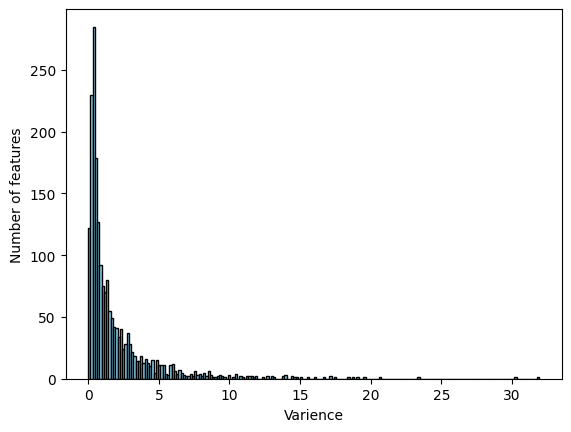

In [81]:
# Plotting ahistogram
var= X_train.var(axis='rows')
print(X_train.shape)
plt.hist(var, bins=200, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Varience')
plt.ylabel('Number of features')

# Display the plot
plt.show()


In [82]:
def analyze_with_feature_selection(X_train, y_train, X_test, y_test, label_info):
    pipe = Pipeline([
        ('feature_selection', VarianceThreshold()),
        ("logistic", LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000))
    ])

    param_grid = {
        'feature_selection__threshold': [0, 1, 5, 2, 10]
    }

    logistic_grid = GridSearchCV(pipe, param_grid=param_grid, cv=10, scoring="balanced_accuracy")
    logistic_grid.fit(X_train, y_train)

    print(f'Metrics for {label_info} mislabels in the data:')
    predicted = logistic_grid.predict(X_test)
    print(classification_report(y_test, predicted))
    print('Best parameters obtained from Grid Search:\n', logistic_grid.best_params_, '\n')

analyze_with_feature_selection(X_train, y_train, X_test, y_test, "no")
analyze_with_feature_selection(X_train, light_mislabel, X_test, y_test, "5%")
analyze_with_feature_selection(X_train, mid_mislabel, X_test, y_test, "30%")
analyze_with_feature_selection(X_train, hard_mislabel, X_test, y_test, "70%")

Metrics for no mislabels in the data:
              precision    recall  f1-score   support

          BC       1.00      1.00      1.00       240
         GBM       1.00      0.97      0.98        33
          KI       1.00      1.00      1.00       118
          LU       1.00      1.00      1.00       118
          OV       1.00      1.00      1.00        60
           U       0.90      1.00      0.95         9

    accuracy                           1.00       578
   macro avg       0.98      0.99      0.99       578
weighted avg       1.00      1.00      1.00       578

Best parameters obtained from Grid Search:
 {'feature_selection__threshold': 1} 

Metrics for 5% mislabels in the data:
              precision    recall  f1-score   support

          BC       0.41      0.33      0.37       240
         GBM       0.10      0.15      0.12        33
          KI       0.24      0.25      0.24       118
          LU       0.22      0.24      0.23       118
          OV       0.12     

### 11. Effect of misslabelling on Feature selection based on F-score + Logistic Regression (to do)

In [83]:
def analyze_with_fscore_feature_selection(X_train, y_train, X_test, y_test, label_info):
    pipe = Pipeline([
        ('feature_selection0', VarianceThreshold(threshold=0)),  # Remove constant features
        ('feature_selection', SelectPercentile(f_classif)),       # F-test for feature selection
        ("logistic", LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000))
    ])

    param_grid = {
        "feature_selection__percentile": [5, 40, 60, 80, 90]
    }

    grid_fscore = GridSearchCV(pipe, param_grid=param_grid, cv=10, scoring="balanced_accuracy")
    grid_fscore.fit(X_train, y_train)

    best_params = grid_fscore.best_params_

    # Best fpipe
    best_pipe = Pipeline([
        ('feature_selection0', VarianceThreshold(threshold=0)),
        ('feature_selection', SelectPercentile(f_classif, percentile=best_params['feature_selection__percentile'])),
        ("logistic", LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000))
    ])

    # Fit best pipe to train
    best_pipe.fit(X_train, y_train)

    # Predict test
    test_predictions = best_pipe.predict(X_test)

    print(f'Metrics for {label_info} mislabels in the data:')
    print("Classification Report for Test Data:")
    print(classification_report(y_test, test_predictions))
    print('Best parameters obtained from Grid Search:\n', best_params, '\n')

# Perform the analysis for different levels of mislabeling
analyze_with_fscore_feature_selection(X_train, y_train, X_test, y_test, "no")
analyze_with_fscore_feature_selection(X_train, light_mislabel, X_test, y_test, "5%")
analyze_with_fscore_feature_selection(X_train, mid_mislabel, X_test, y_test, "30%")
analyze_with_fscore_feature_selection(X_train, hard_mislabel, X_test, y_test, "70%")


Metrics for no mislabels in the data:
Classification Report for Test Data:
              precision    recall  f1-score   support

          BC       1.00      1.00      1.00       240
         GBM       1.00      1.00      1.00        33
          KI       1.00      1.00      1.00       118
          LU       1.00      0.99      1.00       118
          OV       1.00      1.00      1.00        60
           U       1.00      1.00      1.00         9

    accuracy                           1.00       578
   macro avg       1.00      1.00      1.00       578
weighted avg       1.00      1.00      1.00       578

Best parameters obtained from Grid Search:
 {'feature_selection__percentile': 40} 

Metrics for 5% mislabels in the data:
Classification Report for Test Data:
              precision    recall  f1-score   support

          BC       0.43      0.39      0.41       240
         GBM       0.05      0.06      0.05        33
          KI       0.23      0.23      0.23       118
      